# Exploratory HSF statistics notebook

Not intended/designed for any presentation/paper/report, this is purely exploratory and stemmed from internal discussions, but keeping it here as a record and to reproduce it.

Specifically, Nikola wanted to see some t-tests/ANOVA between vendors using Agah's HSF dashboard data.

Mathieu points out that the difficulty in doing "correct" statistics stem from some of assumptions of independence, specifically that some sites shared the same phantom, some sites acquired multiple measurements using the same implementation or one group implemented the sequence at multiple sites. Also, GE was only acquired by two submissions (on three scanners), most Philips measurements came from a single submission, etc. To see a diagram of the distribution of datasets, [click here](https://rrsg2020.github.io/paper/_images/figure_3_full.png).

So all that to say, take the results below with a grain of salt if you aren't Mathieu/Nikola or haven't discussed it with them.

Note: Duplicate T1 maps stemming from the same measurement (i.e. when both magnitude-only and complex T1 mapping data were used) were removed, so only one T1 map per unique measuement exists in the HSF pickled files.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np
from scipy import stats
import os
import shutil

from src.database import *
from src.nist import get_reference_NIST_values, get_NIST_ids
from src.tools import calc_error
from src.nist import temperature_correction

import matplotlib.pyplot as plt
plt.style.use('custom_matplotlibrc')
plt.rcParams["figure.figsize"] = (10,10)


## Load Agah's pickled data from Juan's R dashboard
Note: Agah only emailed me the actual pickled files when generating the paper figures - need to get instruction by him on how to reproduce these. If I were to guess, it would be to go to Juan's dahsboard repo and use [this file](https://github.com/rrsg2020/rrsg2020-stats-dashboard/blob/main/hierarchical_shift_function.R) and "pickle" the outputs.

In [2]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots

init_notebook_mode(connected=True) 

def explode_mount_traces(xp,mosaic,rw,cl,shw):
    traces = []
    for trace in range(len(xp["data"])):
        if not shw:
            xp["data"][trace]['showlegend'] = False
        traces.append(xp["data"][trace])
    for trc in traces:
        mosaic.append_trace(trc, row=rw, col=cl)
    return mosaic    
    

sites = pd.read_pickle("./databases/R_HSF_sites.pkl")



In [3]:
# Slice tables per sphere
sphere_1=sites[sites['sphere']==1]
sphere_2=sites[sites['sphere']==2]
sphere_3=sites[sites['sphere']==3]
sphere_4=sites[sites['sphere']==4]
sphere_5=sites[sites['sphere']==5]
sphere_6=sites[sites['sphere']==6]

# Sphere 1

In [4]:
# Slice sphere tables per vendor
GE_sphere_1=sphere_1[sphere_1['vendor']=='GE']
Siemens_sphere_1=sphere_1[sphere_1['vendor']=='Siemens']
Philips_sphere_1=sphere_1[sphere_1['vendor']=='Philips']

In [5]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_1['id'].unique()
Siemens_meas_ids = Siemens_sphere_1['id'].unique()
Philips_meas_ids = Philips_sphere_1['id'].unique()

print(GE_meas_ids.tolist())
print(Siemens_meas_ids.tolist())
print(Philips_meas_ids.tolist())

['4.001 US', '4.002 US', '10.002 US']
['1.002 London', '2.001 US', '3.001 Montreal', '8.001 Montreal', '8.002 Montreal', '9.001 Australia', '11.002 US', '12.001 Montreal']
['5.002 Montreal', '6.002 Germany', '6.004 Germany', '6.006 Germany', '6.008 Germany', '6.01 Germany', '6.012 Germany', '6.014 Germany', '7.002 Montreal']


In [6]:
# Collapse HSF percentiles to one mean value per scanner measurement
mean_GE_sphere_1 = []
mean_Siemens_sphere_1 = []
mean_Philips_sphere_1 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_1[GE_sphere_1['id']==scanner]
    mean_GE_sphere_1.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_1[Siemens_sphere_1['id']==scanner]
    mean_Siemens_sphere_1.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_1[Philips_sphere_1['id']==scanner]
    mean_Philips_sphere_1.append(np.mean(single_scanner['difference'].tolist()))

In [7]:
# Raw means
print(mean_GE_sphere_1)
print(mean_Siemens_sphere_1)
print(mean_Philips_sphere_1)

[10.238518518518605, 83.17208415798103, -55.09555640088037]
[227.83511670219409, -110.18351375052855, 59.471162057700816, 44.10481481481487, -54.44674775132689, 111.88042296007445, -26.69925925925918, 15.148022848144869]
[19.235060350531462, -42.96338415592082, -58.95338415592086, 185.03024589947523, 177.60036952504566, 61.48269563491782, 65.00777777777782, -6.839273177083265, -126.3129629629629]


In [8]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_1, mean_Siemens_sphere_1))
print(stats.ttest_ind(mean_GE_sphere_1, mean_Philips_sphere_1))
print(stats.ttest_ind(mean_Siemens_sphere_1, mean_Philips_sphere_1))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_1, mean_Siemens_sphere_1, mean_Philips_sphere_1)
print(pvalue)

Ttest_indResult(statistic=-0.31044520455573404, pvalue=0.7632913544593019)
Ttest_indResult(statistic=-0.268302733047986, pvalue=0.7939197314405384)
Ttest_indResult(statistic=0.05946919777831455, pvalue=0.953363465704431)
0.9542141203962895


## Sphere 2

In [9]:
# Slice sphere tables per vendor
GE_sphere_2=sphere_2[sphere_2['vendor']=='GE']
Siemens_sphere_2=sphere_2[sphere_2['vendor']=='Siemens']
Philips_sphere_2=sphere_2[sphere_2['vendor']=='Philips']

In [10]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_2['id'].unique()
Siemens_meas_ids = Siemens_sphere_2['id'].unique()
Philips_meas_ids = Philips_sphere_2['id'].unique()

In [11]:
# Collapse HSF percentiles to one mean value per scanner measurement
mean_GE_sphere_2 = []
mean_Siemens_sphere_2 = []
mean_Philips_sphere_2 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_2[GE_sphere_2['id']==scanner]
    mean_GE_sphere_2.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_2[Siemens_sphere_2['id']==scanner]
    mean_Siemens_sphere_2.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_2[Philips_sphere_2['id']==scanner]
    mean_Philips_sphere_2.append(np.mean(single_scanner['difference'].tolist()))

In [12]:
# Raw means
print(mean_GE_sphere_2)
print(mean_Siemens_sphere_2)
print(mean_Philips_sphere_2)

[16.616666666666738, -38.465651802667125, 18.638834556468485]
[72.61598799677729, -31.61428807076292, 26.168048218420736, 62.264814814814855, 37.40294357142999, 70.8715569820551, 27.870000000000044, 22.798254504444557]
[12.609779265874472, -10.837616407906227, -28.791690481980343, 107.6630656878293, 144.10031603794988, 104.25717256614183, 74.06851851851856, 61.00545684606472, -15.164814814814767]


In [13]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_2, mean_Siemens_sphere_2))
print(stats.ttest_ind(mean_GE_sphere_2, mean_Philips_sphere_2))
print(stats.ttest_ind(mean_Siemens_sphere_2, mean_Philips_sphere_2))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_2, mean_Siemens_sphere_2, mean_Philips_sphere_2)
print(pvalue)

Ttest_indResult(statistic=-1.624037874934912, pvalue=0.13881477461794206)
Ttest_indResult(statistic=-1.3208387844764264, pvalue=0.21598239707799294)
Ttest_indResult(statistic=-0.5544632406208166, pvalue=0.587434311465362)
0.3273063743297731


# Sphere 3

In [14]:
# Slice sphere tables per vendor
GE_sphere_3=sphere_3[sphere_3['vendor']=='GE']
Siemens_sphere_3=sphere_3[sphere_3['vendor']=='Siemens']
Philips_sphere_3=sphere_3[sphere_3['vendor']=='Philips']

In [15]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_3['id'].unique()
Siemens_meas_ids = Siemens_sphere_3['id'].unique()
Philips_meas_ids = Philips_sphere_3['id'].unique()

In [16]:
# Collapse HSF percentiles to one mean value per scanner measurement
mean_GE_sphere_3 = []
mean_Siemens_sphere_3 = []
mean_Philips_sphere_3 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_3[GE_sphere_3['id']==scanner]
    mean_GE_sphere_3.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_3[Siemens_sphere_3['id']==scanner]
    mean_Siemens_sphere_3.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_3[Philips_sphere_3['id']==scanner]
    mean_Philips_sphere_3.append(np.mean(single_scanner['difference'].tolist()))

In [17]:
# Raw means
print(mean_GE_sphere_3)
print(mean_Siemens_sphere_3)
print(mean_Philips_sphere_3)

[-160.7303703703703, -151.48780824363428, -32.87711143476776]
[-15.075165305018155, -65.09453204151757, -10.873688099371444, -35.865555555555474, -55.99463965608433, -19.225177317708372, -130.45999999999995, -0.6584843977774426]
[-36.69957423941829, -55.64417318204325, -66.17380281167286, 2.250230396825133, -0.853037360693722, -29.248589708991858, -31.46925925925921, -34.21404230902777, -81.71740740740736]


In [18]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_3, mean_Siemens_sphere_3))
print(stats.ttest_ind(mean_GE_sphere_3, mean_Philips_sphere_3))
print(stats.ttest_ind(mean_Siemens_sphere_3, mean_Philips_sphere_3))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_3, mean_Siemens_sphere_3, mean_Philips_sphere_3)
print(pvalue)

Ttest_indResult(statistic=-2.159073062254625, pvalue=0.05915666189831824)
Ttest_indResult(statistic=-2.8950019211480784, pvalue=0.015969740538737034)
Ttest_indResult(statistic=-0.26670020539810346, pvalue=0.7933315531451209)
0.029885677216495432


# Sphere 4

In [19]:
# Slice sphere tables per vendor
GE_sphere_4=sphere_4[sphere_4['vendor']=='GE']
Siemens_sphere_4=sphere_4[sphere_4['vendor']=='Siemens']
Philips_sphere_4=sphere_4[sphere_4['vendor']=='Philips']

In [20]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_4['id'].unique()
Siemens_meas_ids = Siemens_sphere_4['id'].unique()
Philips_meas_ids = Philips_sphere_4['id'].unique()

In [21]:
# Collapse HSF percentiles to one mean value per scanner measurement

mean_GE_sphere_4 = []
mean_Siemens_sphere_4 = []
mean_Philips_sphere_4 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_4[GE_sphere_4['id']==scanner]
    mean_GE_sphere_4.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_4[Siemens_sphere_4['id']==scanner]
    mean_Siemens_sphere_4.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_4[Philips_sphere_4['id']==scanner]
    mean_Philips_sphere_4.append(np.mean(single_scanner['difference'].tolist()))

In [22]:
# Raw means
print(mean_GE_sphere_4)
print(mean_Siemens_sphere_4)
print(mean_Philips_sphere_4)

[-203.8148148148148, -283.3969468547454, 4.754188611524581]
[0.6657211913426662, -20.20899539230465, -1.1346400669639378, 3.7677777777777868, -7.462786322751084, 14.152764924768512, -141.3511111111111, -55.25051672518485]
[-39.51672701719609, -18.95590667741361, -20.218128899635822, 19.56848076719546, 21.59307750041343, 9.098638439153357, 4.883703703703708, 4.339554010416704, -25.174074074074056]


In [23]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_4, mean_Siemens_sphere_4))
print(stats.ttest_ind(mean_GE_sphere_4, mean_Philips_sphere_4))
print(stats.ttest_ind(mean_Siemens_sphere_4, mean_Philips_sphere_4))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_4, mean_Siemens_sphere_4, mean_Philips_sphere_4)
print(pvalue)

Ttest_indResult(statistic=-2.3893499826196267, pvalue=0.040600629500444504)
Ttest_indResult(statistic=-3.374802761931636, pvalue=0.00706410304484939)
Ttest_indResult(statistic=-1.1220881385647434, pvalue=0.27946622432686785)
0.005424373669179906


# Sphere 5

In [24]:
# Slice sphere tables per vendor
GE_sphere_5=sphere_5[sphere_5['vendor']=='GE']
Siemens_sphere_5=sphere_5[sphere_5['vendor']=='Siemens']
Philips_sphere_5=sphere_5[sphere_5['vendor']=='Philips']

In [25]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_5['id'].unique()
Siemens_meas_ids = Siemens_sphere_5['id'].unique()
Philips_meas_ids = Philips_sphere_5['id'].unique()

In [26]:
# Collapse HSF percentiles to one mean value per scanner measurement
mean_GE_sphere_5 = []
mean_Siemens_sphere_5 = []
mean_Philips_sphere_5 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_5[GE_sphere_5['id']==scanner]
    mean_GE_sphere_5.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_5[Siemens_sphere_5['id']==scanner]
    mean_Siemens_sphere_5.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_5[Philips_sphere_5['id']==scanner]
    mean_Philips_sphere_5.append(np.mean(single_scanner['difference'].tolist()))

In [27]:
# Raw means
print(mean_GE_sphere_5)
print(mean_Siemens_sphere_5)
print(mean_Philips_sphere_5)


[-59.02962962962964, -82.35586638020831, 21.68946290219911]
[4.12777410641203, -7.022923136148841, -15.418364438657383, -0.02518518518519386, -2.2215320370370364, 13.045134551504601, -39.229629629629656, 0.39892904222222747]
[-25.84679976851851, -5.731127934027793, -4.757794600694455, 24.160389444444476, 14.11835179108799, 3.822041296296277, -1.0962962962963034, 0.45354595486111293, -13.598518518518524]


In [28]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_5, mean_Siemens_sphere_5))
print(stats.ttest_ind(mean_GE_sphere_5, mean_Philips_sphere_5))
print(stats.ttest_ind(mean_Siemens_sphere_5, mean_Philips_sphere_5))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_5, mean_Siemens_sphere_5, mean_Philips_sphere_5)
print(pvalue)

Ttest_indResult(statistic=-1.7210122821228842, pvalue=0.1193559769168836)
Ttest_indResult(statistic=-2.111181590492552, pvalue=0.06092096388676267)
Ttest_indResult(statistic=-0.6583950357083797, pvalue=0.5202626508697117)
0.06673723177452698


# Sphere 6

In [29]:
# Slice sphere tables per vendor
GE_sphere_6=sphere_6[sphere_6['vendor']=='GE']
Siemens_sphere_6=sphere_6[sphere_6['vendor']=='Siemens']
Philips_sphere_6=sphere_6[sphere_6['vendor']=='Philips']

In [30]:
# Get lists of T1 measurements IDs
GE_meas_ids = GE_sphere_6['id'].unique()
Siemens_meas_ids = Siemens_sphere_6['id'].unique()
Philips_meas_ids = Philips_sphere_6['id'].unique()

In [31]:
# Collapse HSF percentiles to one mean value per scanner measurement
mean_GE_sphere_6 = []
mean_Siemens_sphere_6 = []
mean_Philips_sphere_6 = []

for scanner in GE_meas_ids:
    single_scanner=GE_sphere_6[GE_sphere_6['id']==scanner]
    mean_GE_sphere_6.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Siemens_meas_ids:
    single_scanner=Siemens_sphere_6[Siemens_sphere_6['id']==scanner]
    mean_Siemens_sphere_6.append(np.mean(single_scanner['difference'].tolist()))

for scanner in Philips_meas_ids:
    single_scanner=Philips_sphere_6[Philips_sphere_6['id']==scanner]
    mean_Philips_sphere_6.append(np.mean(single_scanner['difference'].tolist()))

In [32]:
# Raw means
print(mean_GE_sphere_6)
print(mean_Siemens_sphere_6)
print(mean_Philips_sphere_6)

[-28.04037037037034, -84.46218462094905, 9.350071711723432]
[3.9484034478009185, -0.09778852618832287, -1.7551220444773636, -31.0922222222222, -32.377728439153316, 10.370886530671308, -16.2622222222222, 2.931727359258888]
[-1.773545800264723, 0.9065175553899394, -1.8216305927582286, 19.519385846560713, -22.56585421420249, -28.038657539682138, -31.898148148148135, -28.836768026620334, -34.942222222222206]


In [33]:
# Two group t-tests (independent)
print(stats.ttest_ind(mean_GE_sphere_6, mean_Siemens_sphere_6))
print(stats.ttest_ind(mean_GE_sphere_6, mean_Philips_sphere_6))
print(stats.ttest_ind(mean_Siemens_sphere_6, mean_Philips_sphere_6))

# One way anova
fvalue, pvalue = stats.f_oneway(mean_GE_sphere_6, mean_Siemens_sphere_6, mean_Philips_sphere_6)
print(pvalue)

Ttest_indResult(statistic=-1.463981423224981, pvalue=0.17723267546515367)
Ttest_indResult(statistic=-1.1064207337757475, pvalue=0.29445008840318165)
Ttest_indResult(statistic=0.7304361120900091, pvalue=0.4763782200872042)
0.27490841588805615


## Summary Table


In [34]:
## Summary Table

import pandas as pd
import dataframe_image as dfi

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)


columns = [
    'T-test (GE vs Siemens)',
    'T-test (GE vs Philips)',
    'T-test (Siemens vs Philips)',
    'ANOVA',
]

col_vals = [
    None,
    None,
    None,
    None,
]

df_setup = {
    'Sphere 1': col_vals,
    'Sphere 2': col_vals,
    'Sphere 3': col_vals,
    'Sphere 4': col_vals,
    'Sphere 5': col_vals,
    'Sphere 6': col_vals,
}

stats_table = pd.DataFrame.from_dict(df_setup, orient='index', columns=columns)

stats_table['T-test (GE vs Siemens)']['Sphere 1'] = stats.ttest_ind(mean_GE_sphere_1, mean_Siemens_sphere_1).pvalue
stats_table['T-test (GE vs Siemens)']['Sphere 2'] = stats.ttest_ind(mean_GE_sphere_2, mean_Siemens_sphere_2).pvalue
stats_table['T-test (GE vs Siemens)']['Sphere 3'] = stats.ttest_ind(mean_GE_sphere_3, mean_Siemens_sphere_3).pvalue
stats_table['T-test (GE vs Siemens)']['Sphere 4'] = stats.ttest_ind(mean_GE_sphere_4, mean_Siemens_sphere_4).pvalue
stats_table['T-test (GE vs Siemens)']['Sphere 5'] = stats.ttest_ind(mean_GE_sphere_5, mean_Siemens_sphere_5).pvalue
stats_table['T-test (GE vs Siemens)']['Sphere 6'] = stats.ttest_ind(mean_GE_sphere_6, mean_Siemens_sphere_6).pvalue

stats_table['T-test (GE vs Philips)']['Sphere 1'] = stats.ttest_ind(mean_GE_sphere_1, mean_Philips_sphere_1).pvalue
stats_table['T-test (GE vs Philips)']['Sphere 2'] = stats.ttest_ind(mean_GE_sphere_2, mean_Philips_sphere_2).pvalue
stats_table['T-test (GE vs Philips)']['Sphere 3'] = stats.ttest_ind(mean_GE_sphere_3, mean_Philips_sphere_3).pvalue
stats_table['T-test (GE vs Philips)']['Sphere 4'] = stats.ttest_ind(mean_GE_sphere_4, mean_Philips_sphere_4).pvalue
stats_table['T-test (GE vs Philips)']['Sphere 5'] = stats.ttest_ind(mean_GE_sphere_5, mean_Philips_sphere_5).pvalue
stats_table['T-test (GE vs Philips)']['Sphere 6'] = stats.ttest_ind(mean_GE_sphere_6, mean_Philips_sphere_6).pvalue

stats_table['T-test (Siemens vs Philips)']['Sphere 1'] = stats.ttest_ind(mean_Siemens_sphere_1, mean_Philips_sphere_1).pvalue
stats_table['T-test (Siemens vs Philips)']['Sphere 2'] = stats.ttest_ind(mean_Siemens_sphere_2, mean_Philips_sphere_2).pvalue
stats_table['T-test (Siemens vs Philips)']['Sphere 3'] = stats.ttest_ind(mean_Siemens_sphere_3, mean_Philips_sphere_3).pvalue
stats_table['T-test (Siemens vs Philips)']['Sphere 4'] = stats.ttest_ind(mean_Siemens_sphere_4, mean_Philips_sphere_4).pvalue
stats_table['T-test (Siemens vs Philips)']['Sphere 5'] = stats.ttest_ind(mean_Siemens_sphere_5, mean_Philips_sphere_5).pvalue
stats_table['T-test (Siemens vs Philips)']['Sphere 6'] = stats.ttest_ind(mean_Siemens_sphere_6, mean_Philips_sphere_6).pvalue

stats_table['ANOVA']['Sphere 1'] = stats.f_oneway(mean_GE_sphere_1, mean_Siemens_sphere_1, mean_Philips_sphere_1).pvalue
stats_table['ANOVA']['Sphere 2'] = stats.f_oneway(mean_GE_sphere_2, mean_Siemens_sphere_2, mean_Philips_sphere_2).pvalue
stats_table['ANOVA']['Sphere 3'] = stats.f_oneway(mean_GE_sphere_3, mean_Siemens_sphere_3, mean_Philips_sphere_3).pvalue
stats_table['ANOVA']['Sphere 4'] = stats.f_oneway(mean_GE_sphere_4, mean_Siemens_sphere_4, mean_Philips_sphere_4).pvalue
stats_table['ANOVA']['Sphere 5'] = stats.f_oneway(mean_GE_sphere_5, mean_Siemens_sphere_5, mean_Philips_sphere_5).pvalue
stats_table['ANOVA']['Sphere 6'] = stats.f_oneway(mean_GE_sphere_6, mean_Siemens_sphere_6, mean_Philips_sphere_6).pvalue



In [35]:
print(stats_table)

         T-test (GE vs Siemens) T-test (GE vs Philips) T-test (Siemens vs Philips) ANOVA
Sphere 1          0.76                   0.79                      0.95             0.95
Sphere 2          0.14                   0.22                      0.59             0.33
Sphere 3          0.06                   0.02                      0.79             0.03
Sphere 4          0.04                   0.01                      0.28             0.01
Sphere 5          0.12                   0.06                      0.52             0.07
Sphere 6          0.18                   0.29                      0.48             0.27


## Export

In [36]:
pwd = os.getcwd()
folder_path = Path("plots/11_NIST_hsf_vendor_comparison/")
dfi.export(stats_table, 'NIST_hsf_vendor_comparison.png')

shutil.move('NIST_hsf_vendor_comparison.png', Path(pwd) / folder_path / 'NIST_hsf_vendor_comparison.png')

objc[8023]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa53ccc550) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.110/Libraries/libGLESv2.dylib (0x1121df850). One of the two will be used. Which one is undefined.
33498 bytes written to file /var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/tmpq7wzc6a6/temp.png


PosixPath('/Users/mathieuboudreau/neuropoly/github/analysis/plots/11_NIST_hsf_vendor_comparison/NIST_hsf_vendor_comparison.png')

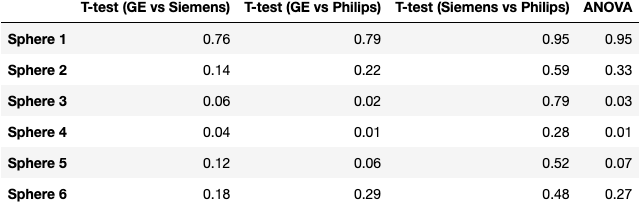

In [37]:
from IPython.display import Image
Image(filename=Path(pwd) / folder_path / 'NIST_hsf_vendor_comparison.png') 